# check gpu resources

In [1]:
# gpu resources
! nvidia-smi

Wed Mar 31 03:28:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 18%   39C    P8    20W / 250W |      5MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 18%   

# testing ManTraNet on different datasets

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import requests
import sys

from PIL import Image
from io import BytesIO
from matplotlib import pyplot

In [3]:
# ManTraNet paths
manTraNet_root = './'
manTraNet_srcDir = os.path.join( manTraNet_root, 'src' )
sys.path.insert( 0, manTraNet_srcDir )
manTraNet_modelDir = os.path.join( manTraNet_root, 'pretrained_weights' )

# setup dataset paths

In [4]:
# sample ManTraNet datasets included in repo
manTraNet_dataDir = os.path.join( manTraNet_root, 'data' )
sample_file = os.path.join( manTraNet_dataDir, 'samplePairs.csv' )
print(sample_file)
assert os.path.isfile( sample_file ), "ERROR: can NOT find sample data, check `manTraNet_root`"
with open( sample_file ) as IN :
    sample_pairs = [line.strip().split(',') for line in IN.readlines() ]
L = len(sample_pairs)
print("INFO: in total, load", L, "samples")
    
def get_a_random_pair() :
    idx = np.random.randint(0,L)
    return ( os.path.join( manTraNet_dataDir, this ) for this in sample_pairs[idx] ) 

./data/samplePairs.csv
INFO: in total, load 72 samples


In [5]:
# CG-1050 dataset
mfc_data = os.path.join(manTraNet_root, 'openmfc_data')
cg_1050 = os.path.join(mfc_data, 'CG_1050')
cg_1050_description = os.path.join(cg_1050, 'DESCRIPTION')

cg_1050_mask = os.path.join(cg_1050, 'MASK')
cg_1050_original = os.path.join(cg_1050, 'ORIGINAL')
cg_1050_tampered = os.path.join(cg_1050, 'TAMPERED')

# load dataset description

In [6]:
description_path = os.path.join(cg_1050_description, 'Dataset_description_v2.csv')

df = pd.read_csv(description_path)

In [7]:
df.head()

,Unnamed: 0,PHOTO NAME (Original),IMAGE DESCRIPTION,PHOTO PLACE,FOLDER NAME,TAMPERING TYPE,PHOTO NAME (Tampered),OBJECT,LOCATION,FOLDER NAME.1,PHOTO NAME (Mask),Pixel changed
0,0,Im_1,Color 3456x4608,Classroom,T_1,Copy-move,Im1_cm1.jpg,telecomunication tower,Middle left,Mask1,Mask1_cm1.png,Black
1,1,Im_1,Color 3456x4608,Classroom,T_1,Copy-move,Im1_cm2.jpg,Window,Middle left,Mask1,Mask1_cm2.png,Black
2,2,Im_1,Color 3456x4608,Classroom,T_1,Copy-move,Im1_cm3.jpg,Tank,Middle left,Mask1,Mask1_cm3.png,Black
3,3,Im_1,Color 3456x4608,Classroom,T_1,Copy-move,Im1_cm4.jpg,Floor,Upper left,Mask1,Mask1_cm4.png,Black
4,4,Im_1,Color 3456x4608,Classroom,T_1,Cut-paste,Im1_cmfr1.jpg,Church tower,Middle left,Mask1,Mask1_cmfr1.png,Black


In [8]:
df.loc[df['PHOTO NAME (Original)'] == 'Im_12']

,Unnamed: 0,PHOTO NAME (Original),IMAGE DESCRIPTION,PHOTO PLACE,FOLDER NAME,TAMPERING TYPE,PHOTO NAME (Tampered),OBJECT,LOCATION,FOLDER NAME.1,PHOTO NAME (Mask),Pixel changed
121,121,Im_12,Color 4608x3456,Street,T_12,Copy-move,Im12_cm1.jpg,Windows,Middle right,Mask12,Mask12_cm1.png,White
122,122,Im_12,Color 4608x3456,Street,T_12,Copy-move,Im12_cm2.jpg,Sidewalk,Left Low,Mask12,Mask12_cm2.png,White
123,123,Im_12,Color 4608x3456,Street,T_12,Copy-move,Im12_cm3.jpg,Window,Middle right,Mask12,Mask12_cm3.png,Black
124,124,Im_12,Color 4608x3456,Street,T_12,Cut-paste,Im12_cmfr1.jpg,Door,Middle,Mask12,Mask12_cmfr1.png,White
125,125,Im_12,Color 4608x3456,Street,T_12,Colorizing,Im12_col1.jpg,Light pole,Middle left,Mask12,Mask12_col1.png,Black
126,126,Im_12,Color 4608x3456,Street,T_12,Colorizing,Im12_col2.jpg,Door,Middle,Mask12,Mask12_col2.png,Black
127,127,Im_12,Color 4608x3456,Street,T_12,Colorizing,Im12_col3.jpg,Roof,Middle,Mask12,Mask12_col3.png,Black
128,128,Im_12,Color 4608x3456,Street,T_12,Retouching,Im12_r1.jpg,Mountain,Upper middle,Mask12,Mask12_r1.png,Black
129,129,Im_12,Color 4608x3456,Street,T_12,Retouching,Im12_r2.jpg,Floor,Right low,Mask12,Mask12_r2.png,Black
130,130,Im_12,Color 4608x3456,Street,T_12,Retouching,Im12_r3.jpg,Roof,Middle,Mask12,Mask12_r3.png,Black


# build dataset list

In [9]:
df["tamper_path"] = df["FOLDER NAME"] + '/' + df["PHOTO NAME (Tampered)"]
df["mask_path"] = df["FOLDER NAME.1"] + '/' + df["PHOTO NAME (Mask)"]

In [10]:
class Sample:
    def __init__(self, name, tampered, masks, methods):
        self.name = name
        self.tampered = tampered
        self.masks = masks
        self.methods = methods

In [11]:
dataset = []
unique_images = list(df['PHOTO NAME (Original)'].unique())

for image in unique_images:
    tampered = list(df.loc[df['PHOTO NAME (Original)'] == image]['tamper_path'])
    masks = list(df.loc[df['PHOTO NAME (Original)'] == image]['mask_path'])
    methods = list(df.loc[df['PHOTO NAME (Original)'] == image]['TAMPERING TYPE'])
    sample = Sample(name=image,
                   tampered=tampered,
                   masks=masks,
                   methods=methods)
    dataset.append(sample)

# dataset should have 100 original images (there are more tampered and masks)
assert len(dataset) == 100

In [12]:
# for reasons unknown, Masks for images 1 to 15 are organized differently
# the file names do not match the dataset description file

dataset = list(filter(lambda x: int(x.name.split('_')[1]) > 15, dataset))

In [13]:
print(dataset[0].name)
print(dataset[0].tampered)
print(dataset[0].masks)
print(dataset[0].methods)

Im_16
['T_16/Im16_cm1.jpg', 'T_16/Im16_cm2.jpg', 'T_16/Im16_cm3.jpg', 'T_16/Im16_cm4.jpg', 'T_16/Im16_cmfr1.jpg', 'T_16/Im16_col1.jpg', 'T_16/Im16_col2.jpg', 'T_16/Im16_col3.jpg', 'T_16/Im16_r1.jpg', 'T_16/Im16_r2.jpg', 'T_16/Im16_r3.jpg']
['Mask16/Mask16_cm1.png', 'Mask16/Mask16_cm2.png', 'Mask16/Mask16_cm3.png', 'Mask16/Mask16_cm4.png', 'Mask16/Mask16_cmfr1.png', 'Mask16/Mask16_col1.png', 'Mask16/Mask16_col2.png', 'Mask16/Mask16_col3.png', 'Mask16/Mask16_r1.png', 'Mask16/Mask16_r2.png', 'Mask16/Mask16_r3.png']
['Copy-move', 'Copy-move', 'Copy-move', 'Copy-move', 'Cut-paste', 'Colorizing', 'Colorizing', 'Colorizing', 'Retouching', 'Retouching', 'Retouching']


In [14]:
print(len(dataset[0].tampered))
print(len(dataset[0].masks))
print(len(dataset[0].methods))

11
11
11


In [15]:
def get_a_random_sample():
    idx = np.random.randint(0,len(dataset))
    sample = dataset[idx]
    original_path = os.path.join(cg_1050_original, sample.name + '.jpg')
    
    idx_mt = np.random.randint(0,len(sample.tampered)) # each tampered image has a mask, so lengths are the same
    mask_path = os.path.join(cg_1050_mask, sample.masks[idx_mt])
    tampered_path = os.path.join(cg_1050_tampered, sample.tampered[idx_mt])
    method = sample.methods[idx_mt]
    
    return (original_path, mask_path, tampered_path, method)

# Load A Pretrained ManTraNet Model

In [16]:
import modelCore # try running nvidia-smi at the top after the model loads to see model memory requirements
manTraNet = modelCore.load_pretrain_model_by_index( 4, manTraNet_modelDir )

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True


In [17]:
# ManTraNet Architecture 
print(manTraNet.summary(line_length=120))

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
img_in (InputLayer)                    (None, None, None, 3)      0                                                     
________________________________________________________________________________________________________________________
Featex (Model)                         (None, None, None, 256)    3675181       img_in[0][0]                            
________________________________________________________________________________________________________________________
outlierTrans (Conv2D)                  (None, None, None, 64)     16384         Featex[1][0]                            
________________________________________________________________________________________________________________________
bnorm (BatchNormalization)      

In [18]:
# Image Manipulation Classification Network
IMCFeatex = manTraNet.get_layer('Featex')
print(IMCFeatex.summary(line_length=120))

________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
image_in (InputLayer)                                 (None, None, None, 3)                           0                 
________________________________________________________________________________________________________________________
b1c1 (CombinedConv2D)                                 (None, None, None, 16)                          525               
________________________________________________________________________________________________________________________
b1c2 (Conv2DSymPadding)                               (None, None, None, 32)                          4640              
________________________________________________________________________________________________________________________
b2c1 (Conv2DSymPadding)         

# test samples from cg-1050

In [19]:
from datetime import datetime 
def read_rgb_image( image_file ) :
    rgb = cv2.imread( image_file, 1 )[...,::-1]
    return rgb
    
def decode_an_image_array( rgb, manTraNet ) :
    x = np.expand_dims( rgb.astype('float32')/255.*2-1, axis=0 )
    t0 = datetime.now()
    y = manTraNet.predict(x)[0,...,0]
    t1 = datetime.now()
    return y, t1-t0

def decode_an_image_file( image_file, manTraNet ) :
    rgb = read_rgb_image( image_file )
    mask, ptime = decode_an_image_array( rgb, manTraNet )
    return rgb, mask, ptime.total_seconds()

./openmfc_data/CG_1050/ORIGINAL/Im_88.jpg
./openmfc_data/CG_1050/MASK/Mask88/Mask88_col1.png
./openmfc_data/CG_1050/TAMPERED/T_88/Im88_col1.jpg
tampering method: Copy-move
True
True
True
w = 3456
h = 4608
new w x h = (864, 1152)
w = 3456
h = 4608
new w x h = (864, 1152)


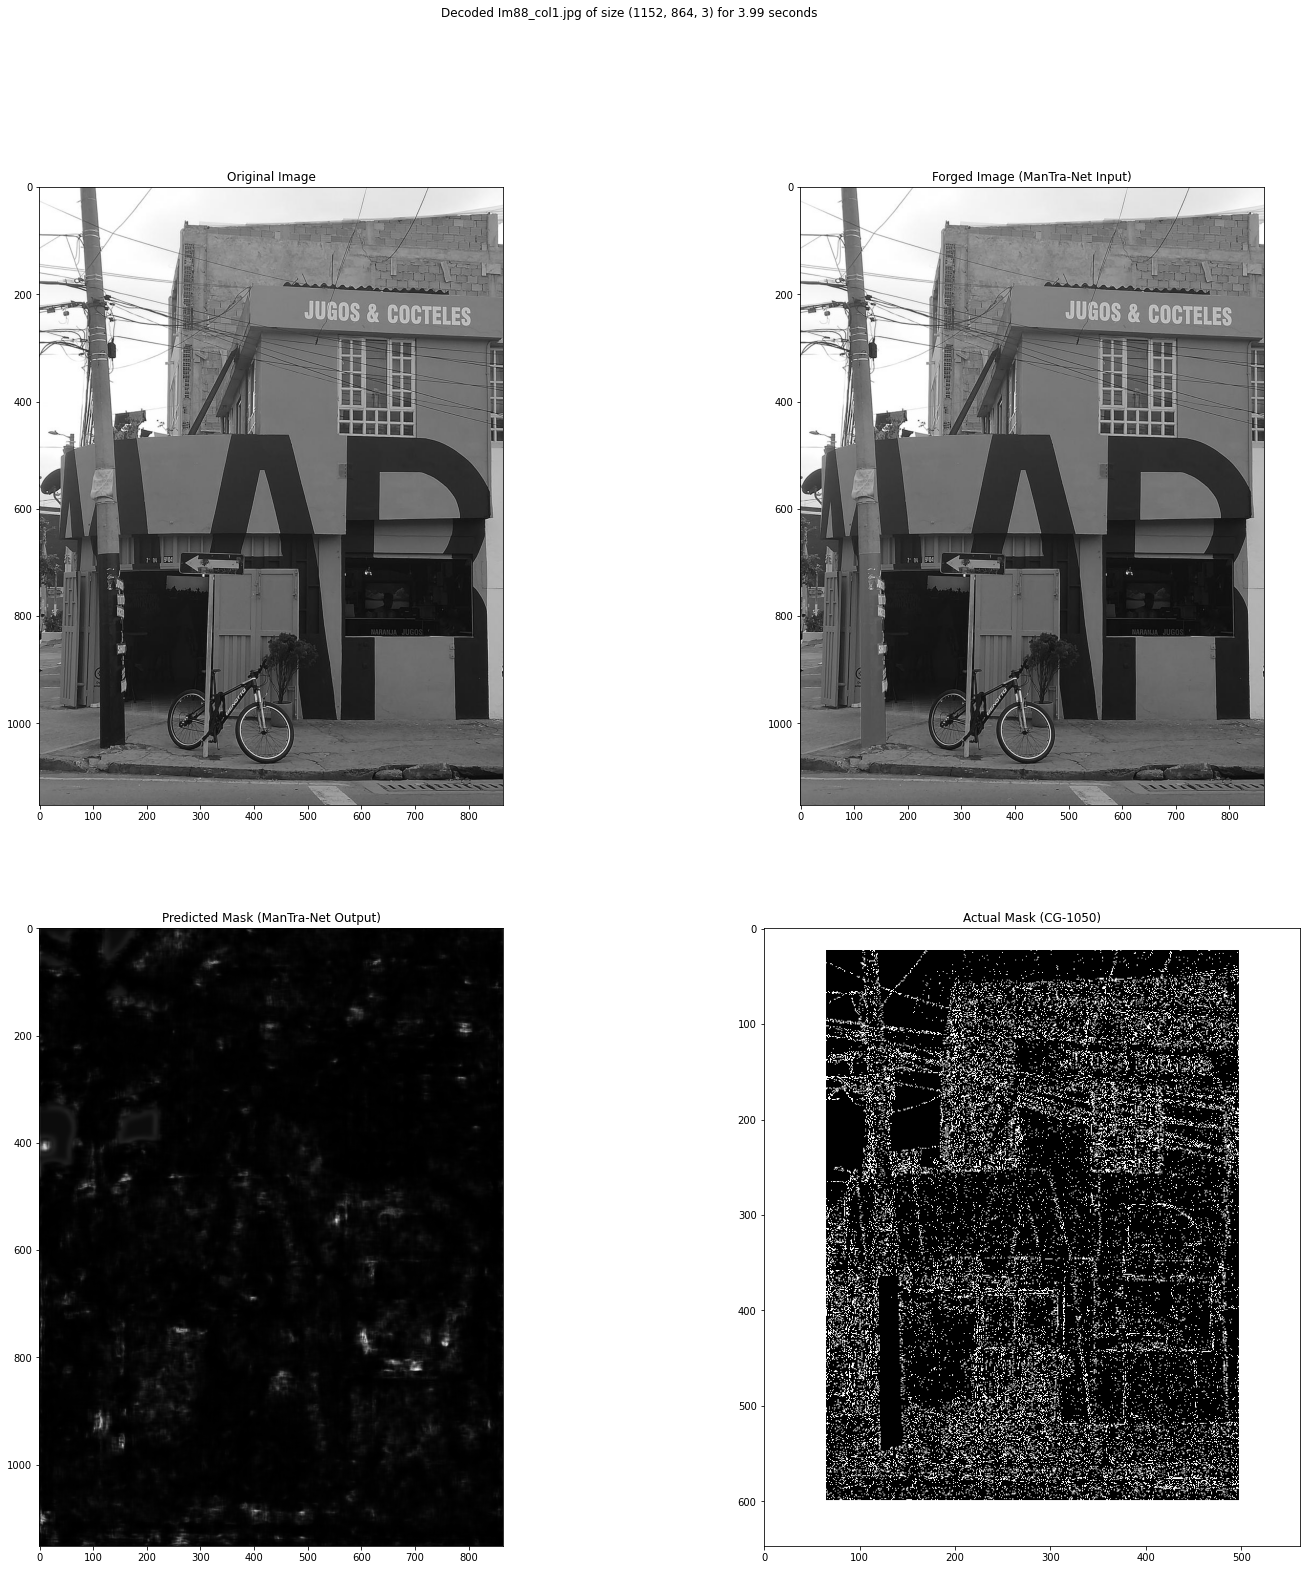

In [20]:
# modified for CG-1050 dataset

for k in range(8) :
    # get a sample
    orig_file, mask_file, tampered_file, tamper_method = get_a_random_sample()
    print(orig_file)
    print(mask_file)
    print(tampered_file)
    print(f'tampering method: {tamper_method}')
    print(os.path.exists(orig_file))
    print(os.path.exists(mask_file))
    print(os.path.exists(tampered_file))
    
    # resize image test
    original_image = Image.open(orig_file)
    original_filename = os.path.basename(orig_file)
    tampered_image = Image.open(tampered_file)
    tampered_filename = os.path.basename(tampered_file)
    
    # original
    print(f'w = {tampered_image.width}')
    print(f'h = {tampered_image.height}')
    print(f'new w x h = {(tampered_image.width // 4, tampered_image.height // 4)}')
    tmpr_img_resize = tampered_image.resize((tampered_image.width // 4, tampered_image.height // 4))
    tmpr_resized_filename = 'resized_' + tampered_filename
    tmpr_img_resize.save(tmpr_resized_filename)
    
    # tampered
    print(f'w = {original_image.width}')
    print(f'h = {original_image.height}')
    print(f'new w x h = {(original_image.width // 4, original_image.height // 4)}')
    orig_img_resize = original_image.resize((original_image.width // 4, original_image.height // 4))
    orig_resized_filename = 'resized_' + original_filename
    orig_img_resize.save(orig_resized_filename)
    
    # load the original image for reference
    ori = read_rgb_image( orig_resized_filename )
    # manipulation detection using ManTraNet
    rgb, mask, ptime = decode_an_image_file( tmpr_resized_filename, manTraNet )
    
    # show results
    pyplot.figure( figsize=(25,25) )
    
    pyplot.subplot(2, 2, 1)
    pyplot.imshow( ori )
    pyplot.title('Original Image')
    
    pyplot.subplot(2, 2, 2)
    pyplot.imshow( rgb )
    pyplot.title('Forged Image (ManTra-Net Input)')
    
    pyplot.subplot(2, 2, 3)
    pyplot.imshow( mask, cmap='gray' )
    pyplot.title('Predicted Mask (ManTra-Net Output)')

    pyplot.subplot(2, 2, 4)
    actual_mask = pyplot.imread(mask_file)
    pyplot.imshow(actual_mask, cmap='gray')
    pyplot.title('Actual Mask (CG-1050)')
    
    pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( os.path.basename( tampered_file ), rgb.shape, ptime ) )
    
    pyplot.show()
    
    break # remove break to test on more images